In [18]:
# To avoid the error while plotting "AttributeError: 'GeoAxes' object has no attribute '_autoscaleXon'"
!pip install --user matplotlib==3.5.2

In [2]:
import matplotlib
print("Matplotlib version:", matplotlib.__version__)

Matplotlib version: 3.5.2


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from nansat import Nansat, Domain, NSR

from sea_ice_drift import get_n
from sea_ice_drift.ftlib import feature_tracking
from sea_ice_drift.pmlib import pattern_matching

import csv

%matplotlib inline

In [6]:
from osgeo import gdal
from osgeo import osr

from sea_ice_drift.lib import get_spatial_mean, get_uint8_image

In [7]:
# Download arrays
f0 = gdal.Open('/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/HV_160/S1A_EW_GRDM_1SDH_20230212T080151_20230212T080255_047200_05A9D0_C7EB_Orb_Cal_TC_HV_160.tif')
f1 = gdal.Open('/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/HV_160/S1A_EW_GRDM_1SDH_20230214T074531_20230214T074635_047229_05AAC8_4014_Orb_Cal_TC_HV_160.tif')
f2 = gdal.Open('/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_forecast/HV/sar2_model/Aligned_model_full_S1A_EW_GRDM_1SDH_20230212T080151_20230212T080255_047200_05A9D0_C7EB_Orb_Cal_TC_HV_160.tif')
f3 = gdal.Open('/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_forecast/HV/sar2_alg_gpi/Aligned_alg_gpi_S1A_EW_GRDM_1SDH_20230212T080151_20230212T080255_047200_05A9D0_C7EB_Orb_Cal_TC_HV_160.tif')

In [8]:
#Set domains based on the data
n0_domen = Nansat('/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/HV_160/S1A_EW_GRDM_1SDH_20230212T080151_20230212T080255_047200_05A9D0_C7EB_Orb_Cal_TC_HV_160.tif')
n1_domen = Nansat('/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/HV_160/S1A_EW_GRDM_1SDH_20230214T074531_20230214T074635_047229_05AAC8_4014_Orb_Cal_TC_HV_160.tif')
n2_domen = Nansat('/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_forecast/HV/sar2_model/Aligned_model_full_S1A_EW_GRDM_1SDH_20230212T080151_20230212T080255_047200_05A9D0_C7EB_Orb_Cal_TC_HV_160.tif')
n3_domen = Nansat('/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_forecast/HV/sar2_alg_gpi/Aligned_alg_gpi_S1A_EW_GRDM_1SDH_20230212T080151_20230212T080255_047200_05A9D0_C7EB_Orb_Cal_TC_HV_160.tif')

In [9]:
#Load the data from the files into numpy arrays for further processing.
a0 = f0.ReadAsArray() 
a1 = f1.ReadAsArray() 
a2 = f2.ReadAsArray()
a3 = f3.ReadAsArray()

#Pre-process images to ensure consistent visualization and handle blank spots issue after pattern patching.
a0 = get_uint8_image(a0, None, None, 1, 99)
a1 = get_uint8_image(a1, None, None, 1, 99)
a2 = get_uint8_image(a2, None, None, 1, 99)
a3 = get_uint8_image(a3, None, None, 1, 99)

VMIN:  0.0
VMAX:  0.021238385755568752
VMIN:  0.0
VMAX:  0.01598892150446774
VMIN:  0.0018502648966386914
VMAX:  0.02133365400135518
VMIN:  0.0017477583931759
VMAX:  0.022014104276895523


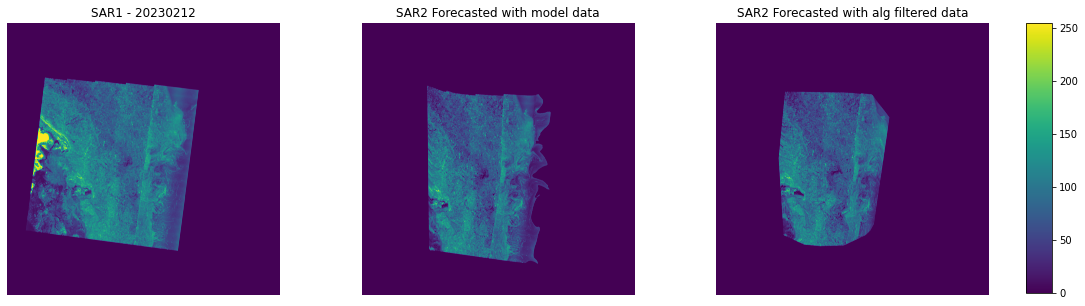

In [10]:
#Plot
fig, ax = plt.subplots(1,3, figsize=(18,5))
im1 = ax[0].imshow(a0, clim=[0, 255])
ax[0].axis('off')
#plt.colorbar(im0, ax=ax[0])
im2 = ax[1].imshow(a2, clim=[0, 255])
ax[1].axis('off')
#plt.colorbar(im1, ax=ax[1])
im3 = ax[2].imshow(a3, clim=[0, 255])
ax[2].axis('off')
cax = fig.add_axes([0.92, 0.13, 0.02, 0.75])  # Position and size of the colorbar
cbar = fig.colorbar(im3, cax=cax)
#plt.colorbar(im3, ax=ax[2])

ax[0].set_title("SAR1 - 20230212")
ax[1].set_title("SAR2 Forecasted with model data")
ax[2].set_title("SAR2 Forecasted with alg filtered data")
plt.show()

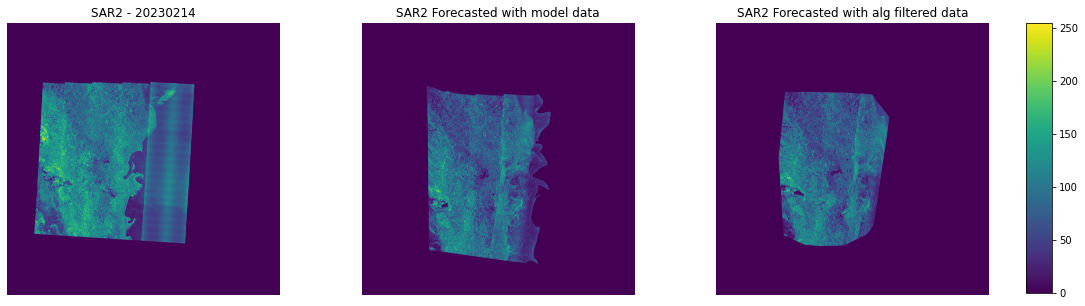

In [11]:
#Plot
fig, ax = plt.subplots(1,3, figsize=(18,5))
im1 = ax[0].imshow(a1, clim=[0, 255])
ax[0].axis('off')
#plt.colorbar(im0, ax=ax[0])
im2 = ax[1].imshow(a2, clim=[0, 255])
ax[1].axis('off')
#plt.colorbar(im1, ax=ax[1])
im3 = ax[2].imshow(a3, clim=[0, 255])
ax[2].axis('off')
cax = fig.add_axes([0.92, 0.13, 0.02, 0.75])  # Position and size of the colorbar
cbar = fig.colorbar(im3, cax=cax)
#plt.colorbar(im3, ax=ax[2])

ax[0].set_title("SAR2 - 20230214")
ax[1].set_title("SAR2 Forecasted with model data")
ax[2].set_title("SAR2 Forecasted with alg filtered data")
plt.show()

In [12]:
# Create three Nansat objects with original tiff domains imported from gdal object.

n0 = Nansat.from_domain(n0_domen, a0)
n1 = Nansat.from_domain(n1_domen, a1)
n2 = Nansat.from_domain(n2_domen, a2)
n3 = Nansat.from_domain(n3_domen, a3)

In [13]:
# Close the dataset
f0 = None
f1 = None
f2 = None
f3 = None

In [14]:
# Run Feature Tracking
# get start/end coordinates in the image coordinate system (colums/rows)  
c1, r1, c2, r2 = feature_tracking(n1, n2, nFeatures=50000, ratio_test=0.6, max_drift=100000, verbose=True)

Key points found: 50000
Key points found: 50000
Domain filter: 50000 -> 50000
Domain filter: 50000 -> 50000
Keypoints matched 5.07734489440918
Ratio test 0.600000 found 575 keypoints
MaxDrift filter: 575 -> 572
LSTSQ filter: 572 -> 570


In [55]:
%store -r lon1b
%store -r lat1b
%store -r lon2b
%store -r lat2b

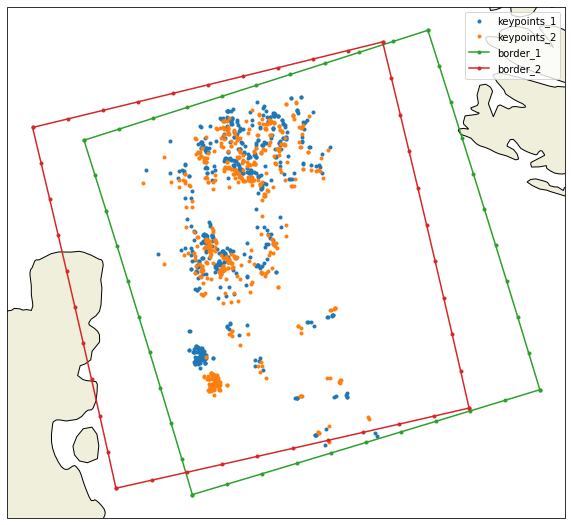

In [56]:
# Plot identified and matched keypoints in geographic coordinates

# convert row/column coordinates of matched features to lon/lat
lon1ft, lat1ft = n1.transform_points(c1, r1)
lon2ft, lat2ft = n2.transform_points(c2, r2)

# get lon/lat coordinates of the border of images
#lon1b, lat1b = n1.get_border()
#lon2b, lat2b = n2.get_border()


# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70))
ax.add_feature(land_50m, zorder=0, edgecolor='black')
ax.plot(lon1ft, lat1ft, '.', label='keypoints_1', transform=ccrs.PlateCarree())
ax.plot(lon2ft, lat2ft, '.', label='keypoints_2', transform=ccrs.PlateCarree())
ax.plot(lon1b, lat1b, '.-', label='border_1', transform=ccrs.PlateCarree())
ax.plot(lon2b, lat2b, '.-', label='border_2', transform=ccrs.PlateCarree())
ax.legend()
plt.show()

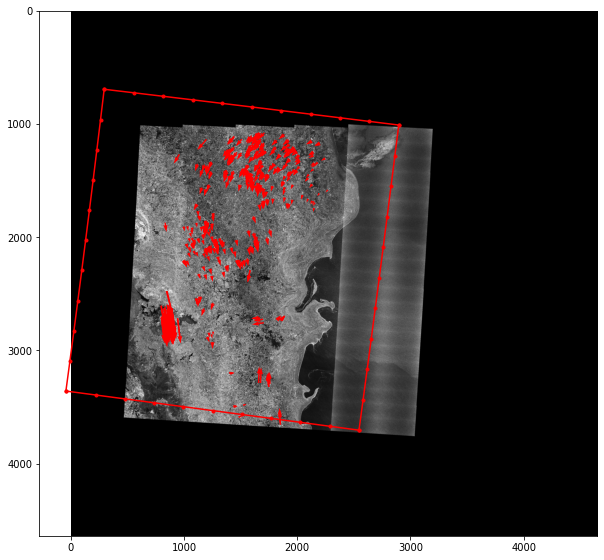

In [72]:

# Plot ice drift on top of image_1

# end points in image_1 coordinate system
n1c2, n1r2 = n1.transform_points(lon2ft, lat2ft, DstToSrc=1)

# ice drift components in image_1 coordinate system
dr = n1r2 - r1
dc = n1c2 - c1

# border of image_2 in image_1 coordinate system
n1lon2b, n1lat2b = n1.transform_points(lon2b, lat2b, DstToSrc=1)

# plot of ice drift. Arrows are 5 times longer than actual drift
plt.figure(figsize=(10,10))
plt.imshow(n1[1], cmap='gray')
plt.quiver(c1, r1, dc, dr, color='r', angles='xy', scale_units='xy', scale=1)
plt.plot(n1lon2b, n1lat2b, 'r.-')

plt.show()
#filename = '/home/jovyan/work/Icedrift/Nansen_algorithm/Data_and_output/Nansen_output/2500m/FT_example_HH#_1image.png'
#plt.savefig(filename, dpi=300, bbox_inches='tight')

In [17]:
import xarray as xr
data = xr.open_dataset("https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_eps/barents_eps_20230901T00Z.nc")

In [18]:
import xarray as xr
# Setting subset grid using image border coordinates from nanset object
# Open the remote dataset with model data
#data = xr.open_dataset("https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_eps/barents_eps_20230211T18Z.nc")
# Extract X and Y coordinates, as well as longitude and latitude values from the dataset
X = data['X']
Y = data['Y']
lon = data['lon']
lat = data['lat']

# Retrieve the proj4 string defining the Lambert Conformal projection of the dataset
proj4 = data.projection_lambert.proj4
print(proj4)

# Convert the proj4 string to a Nansat spatial reference object
srs = NSR(proj4)

#Get bound in rows and columns correspoding to the image borders set above
r,c = np.where((lon.data > min(lon1b))*(lon.data <  max(lon1b))*(lat.data >  min(lat1b))*(lat.data < max(lat1b)))
               
min_row, max_row, min_col, max_col = min(r), max(r), min(c), max(c)

+proj=lcc +lat_0=77.5 +lon_0=-25 +lat_1=77.5 +lat_2=77.5 +no_defs +R=6.371e+06


In [50]:
lon1b

array([-11.5992,  -5.4989,   0.1943,   5.4244,  10.1728,  14.4493,
        18.2821,  21.7087,  24.7705,  27.5087,  29.9716,  29.9716,
        26.9505,  24.1639,  21.5966,  19.2325,  17.0553,  15.0489,
        13.1981,  11.4888,   9.9081,   8.4165,   8.4165,   6.1447,
         3.7753,   1.2993,  -1.2814,  -3.9628,  -6.7393,  -9.6028,
       -12.5433, -15.5487, -18.6049, -18.6049, -18.2441, -17.8484,
       -17.4038, -16.9007, -16.3267, -15.6659, -14.8971, -13.992 ,
       -12.9112, -11.5992])

In [49]:
lon.shape

(949, 739)

In [48]:
min_row, max_row, min_col, max_col

(268, 763, 0, 424)

In [89]:
%store -r X_subset
%store -r Y_subset
%store -r lon_subset
%store -r lat_subset
%store -r min_row
%store -r max_row
%store -r min_col
%store -r max_col
%store -r lon
%store -r lat

In [90]:
'''
# Extract the subset grif out of the model grid based on the image bounds
#That grid and srs will be used for pattern matching ensuring the drift output aligns easily with the model data.
X_subset = X[min_col:max_col+1]
Y_subset = Y[min_row:max_row+1]
lon_subset = lon[min_row:max_row+1, min_col:max_col+1]
lat_subset = lat[min_row:max_row+1, min_col:max_col+1]
'''


# Prepare coordinates for patern matching input
lon1pm = lon_subset.data
lat1pm = lat_subset.data

# Set up coordinates in meters for visualizing the pattern matching results.
x1pm, y1pm = np.meshgrid(X_subset, Y_subset)

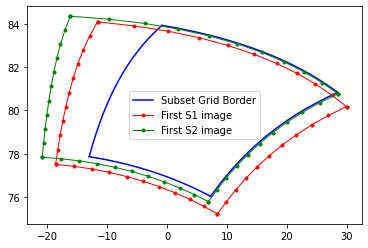

In [91]:
# Plot coverage of the first SAR1 image and subset grid imported from the model
# Top border
plt.plot(lon_subset[0, :], lat_subset[0, :], 'b-', label='Subset Grid Border')
# Bottom border
plt.plot(lon_subset[-1, :], lat_subset[-1, :], 'b-')
# Left border
plt.plot(lon_subset[:, 0], lat_subset[:, 0], 'b-')
# Right border
plt.plot(lon_subset[:, -1], lat_subset[:, -1], 'b-')

plt.plot(*n1.get_border(), '.-', label='First S1 image',markersize=6, linewidth=1, c = 'red')
plt.plot(*n2.get_border(), '.-', label='First S2 image', markersize=6, linewidth=1, c = 'green')
#plt.plot(*dom_pm.get_border(), '.-', label='ROI')
plt.legend()
plt.show()

In [93]:
## Run Pattern Matching for each element in lon1pm/lat1pm matrix
# ice displacement upm and vpm are returned in meters in Stereographic projection
upm, vpm, apm, rpm, hpm, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2,
                                                          srs=srs.ExportToProj4(),
                                                           min_border=100,
                                                           max_border=100,
                                                           angles=[-12, -9,-6, -3, 0, 3, 6, 9, 12])

/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide
/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide
/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide


/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide


/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide


100% 00860.2 00031.7 01067.0 00218.0 -12.0 1.00 0nan0% 02954.2 03406.7 03203.0 03280.0 -12.0 0.00 0nan06% 02657.2 04031.7 02931.0 03940.0 -12.0 1.00 0nan09% 02032.2 03875.7 02317.0 03870.0 -12.0 1.00 0nan14% 02251.2 03672.7 02600.0 03661.0 +06.0 0.21 3.2787% 02610.2 00625.7 02790.0 00571.0 -12.0 1.00 0nan77% 00954.2 01031.7 01267.0 01359.0 -12.0 0.32 4.24
 Pattern matching - OK! (141 sec)


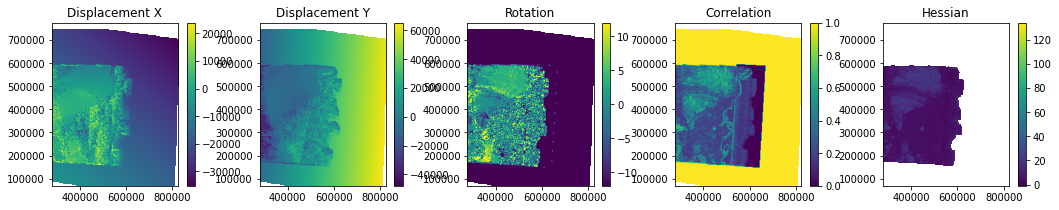

In [94]:
# plot retrieved matrices
titles = ['Displacement X', 'Displacement Y', 'Rotation', 'Correlation', 'Hessian']
fig, ax = plt.subplots(1,5, figsize=(18,3))
for i, a in enumerate([upm, vpm, apm, rpm, hpm]):
    ax[i].set_title(titles[i])
    im = ax[i].imshow(a, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower')
    plt.colorbar(im, ax=ax[i])

plt.show()

In [122]:
model_d

Domain:[10600 x 12374]
----------------------------------------
Projection(dataset):
PROJCS["unknown",
    GEOGCS["unknown",
        DATUM["unknown",
            SPHEROID["unknown",6371000,0]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433]],
    PROJECTION["Lambert_Conformal_Conic_2SP"],
    PARAMETER["latitude_of_origin",77.5],
    PARAMETER["central_meridian",-25],
    PARAMETER["standard_parallel_1",77.5],
    PARAMETER["standard_parallel_2",77.5],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1]]
----------------------------------------
Corners (lon, lat):
	 ( 10.51,  85.76)  ( 50.03,  77.63)
	 (-15.13,  75.24)  ( 15.17,  71.17)

In [123]:
# Model domain to reproject SAR image from 3996
model_d = Domain(srs, f'-te {min(X.data)} {min(Y.data)} {max(X.data)} {max(Y.data)} -tr 100 100')
# reproject n1 for visualizing SAR image in the same projection as model data

# Get n for vizualizaton and reprojecting
n0.reproject(model_d) 
n0b1 = n0[1]
n0.undo()

n1.reproject(model_d) 
n1b1 = n1[1]
n1.undo()

n2.reproject(model_d) 
n2b1 = n2[1]
n2.undo()

n3.reproject(model_d)
n3b1 = n3[1]
n3.undo()

#### Plotting data with hessian

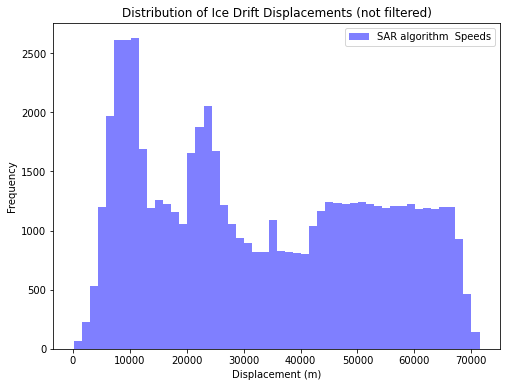

In [26]:
disp_alg = np.sqrt((upm**2+vpm**2))

disp_alg = disp_alg.flatten()


plt.figure(figsize=(8,6))



# Plotting Reference Speed
plt.hist(disp_alg, bins=50, color='blue', alpha=0.5, label='SAR algorithm  Speeds')

plt.xlabel('Displacement (m)')
plt.ylabel('Frequency')
plt.title('Distribution of Ice Drift Displacements (not filtered)')
plt.legend()
plt.show()



Number of True values without filtering : 7940


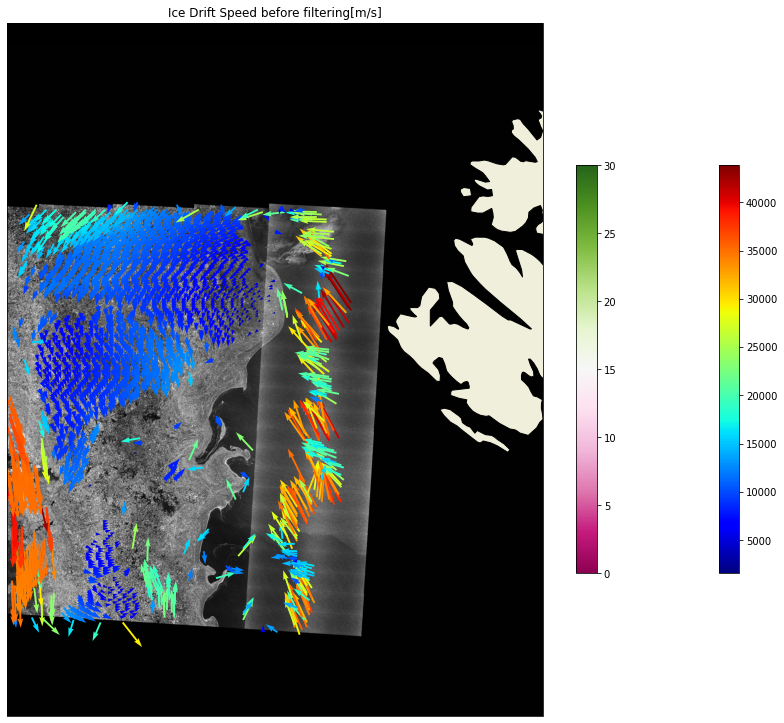

In [124]:
u = upm #/ delta_t
v = vpm #/ delta_t
speed = np.sqrt((v**2+u**2)) 

# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Create a figure with three subplots side by side
plt.figure(figsize=(15,15))
ax =plt.axes(projection=crs) 

# Figure 1

# filter vectors with hessian value
gpi = (hpm > 8) 
num_true_values = np.sum(gpi.data)
print(f"Number of True values without filtering : {num_true_values}")



ax.imshow(n1b1, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
quiv1 = ax.quiver(x1pm[gpi][::4], y1pm[gpi][::4], u[gpi][::4], v[gpi][::4], speed[gpi][::4], scale=500000, cmap='jet', width=0.0035)
#quiv1 = ax.quiver(x1pm[gpi][::1], y1pm[gpi][::1], u[gpi][::1], v[gpi][::1], speed[gpi][::1], scale=2, cmap='jet', width=0.0035)
ax.set_title('Ice Drift Speed before filtering[m/s]')
plt.colorbar(quiv1, ax=ax, orientation='vertical', shrink=0.5)

# Filter out values of hpm 
filtered_hpm = np.where(hpm > 0, hpm, np.nan)
#h_img = ax.imshow(filtered_hpm, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower', cmap='PiYG', alpha=1, vmin=0, vmax=25)
#ax.set_title('Hessian > 9')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xlim([x1pm.min(), x1pm.max()])
ax.set_ylim([y1pm.min(), y1pm.max()])
#ax.set_xlim([x1pm.min(), x1pm.max()-670000])
#ax.set_ylim([y1pm.min()+370000, y1pm.max()-400000])
plt.colorbar(h_img, ax=ax, shrink=0.5)


plt.show()


In [118]:
%store -r gpi_sar1_sar2

Number of True values in gpi before filtering: 8205


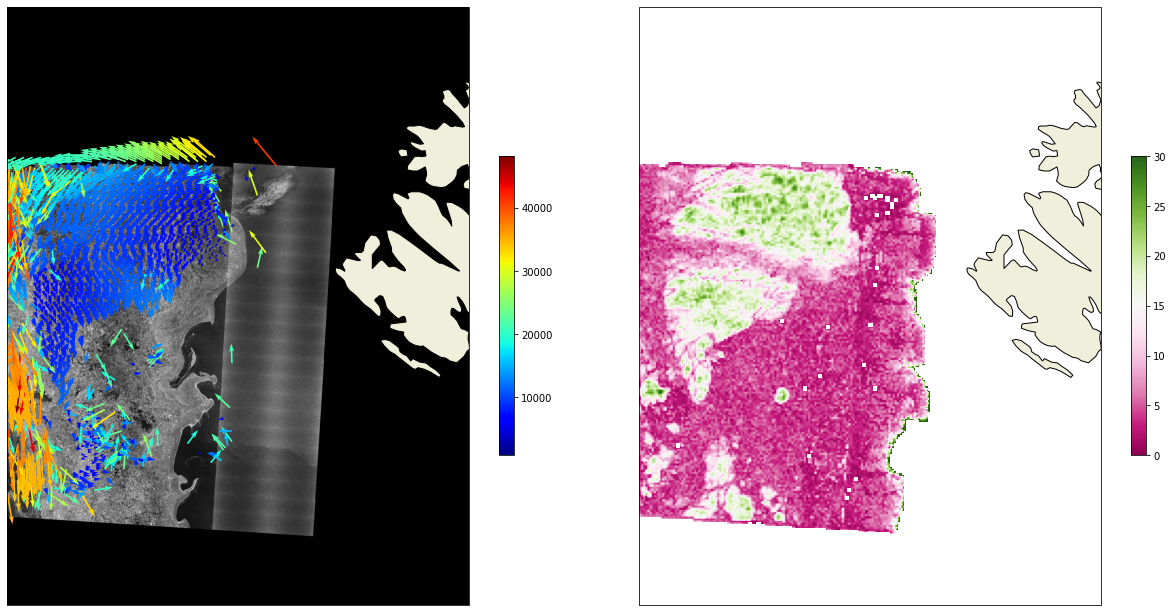

In [126]:
# without steps for visualizing 
u = upm # / delta_t
v = vpm #/ delta_t
speed = np.sqrt((v**2+u**2)) 

# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22,11), subplot_kw={'projection': crs})

# Figure 1

# filter vectors with hessian value
gpi = (hpm > 8)
gpi = gpi_sar1_sar2
num_true_values = np.sum(gpi.data)
print(f"Number of True values in gpi before filtering: {num_true_values}")

ax1.imshow(n1b1, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
quiv1 = ax1.quiver(x1pm[gpi][::4], y1pm[gpi][::4], u[gpi][::4], v[gpi][::4], speed[gpi][::4], scale=500000, cmap='jet', width=0.0035)
#quiv1 = ax.quiver(x1pm[gpi][::1], y1pm[gpi][::1], u[gpi][::1], v[gpi][::1], speed[gpi][::1], scale=1000000, cmap='jet', width=0.0035)
#ax1.set_title('Ice Drift Speed before filtering[m/s]')
ax1.add_feature(land_50m, edgecolor='black')
ax1.set_xlim([x1pm.min(), x1pm.max()])
ax1.set_ylim([y1pm.min(), y1pm.max()])
#ax1.set_xlim([x1pm.min(), x1pm.max()-670000])
#ax1.set_ylim([y1pm.min()+370000, y1pm.max()-400000])
plt.colorbar(quiv1, ax=ax1, orientation='vertical', shrink=0.5)



#  Figure 2

# Filter out values of hpm 
filtered_hpm = np.where(hpm > 0, hpm, np.nan)
h_img = ax2.imshow(filtered_hpm, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower', cmap='PiYG', alpha=1, vmin=0, vmax=30)
#ax2.set_title('Hessian > 9')
ax2.add_feature(land_50m, edgecolor='black')
ax2.set_xlim([x1pm.min(), x1pm.max()])
ax2.set_ylim([y1pm.min(), y1pm.max()])
#ax2.set_xlim([x1pm.min(), x1pm.max()-670000])
#ax2.set_ylim([y1pm.min()+370000, y1pm.max()-400000])
plt.colorbar(h_img, ax=ax2, shrink=0.5)



# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.06)  


#plt.tight_layout()
plt.show()



Number of True values in gpi before filtering: 7940


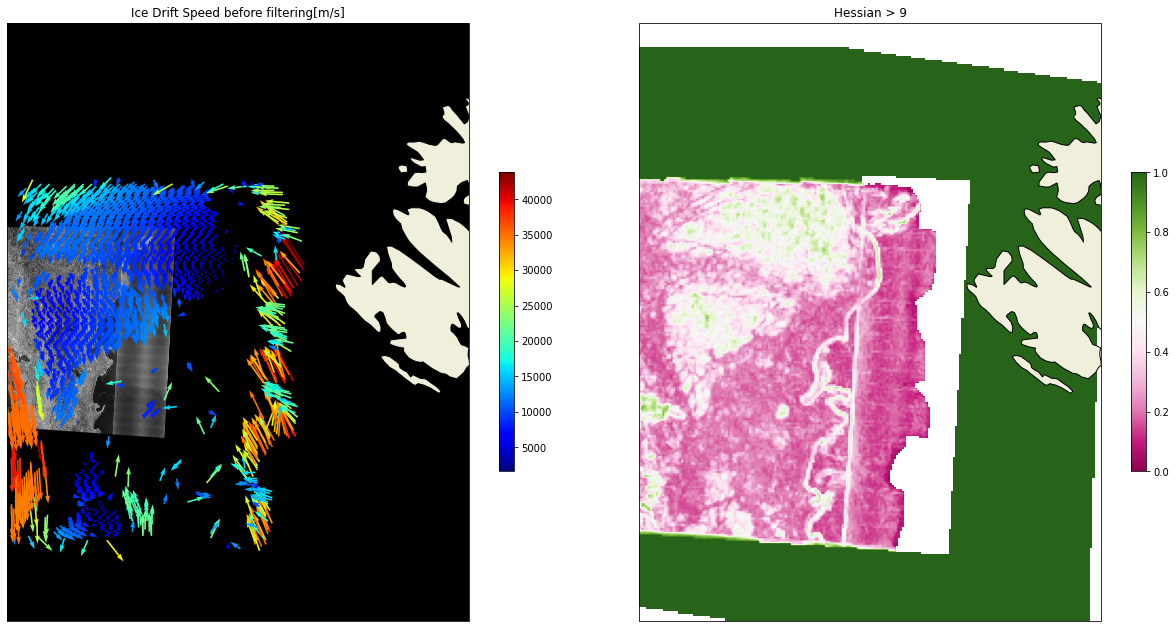

In [109]:
# without steps for visualizing 
u = upm #/ delta_t
v = vpm #/ delta_t
speed = np.sqrt((v**2+u**2)) 

# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22,11), subplot_kw={'projection': crs})

# Figure 1

# filter vectors with hessian value

gpi = (hpm > 8)
num_true_values = np.sum(gpi.data)
print(f"Number of True values in gpi before filtering: {num_true_values}")

ax1.imshow(n1b1, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
quiv1 = ax1.quiver(x1pm[gpi][::4], y1pm[gpi][::4], u[gpi][::4], v[gpi][::4], speed[gpi][::4], scale=500000, cmap='jet', width=0.0035)
#quiv1 = ax.quiver(x1pm[gpi][::1], y1pm[gpi][::1], u[gpi][::1], v[gpi][::1], speed[gpi][::1], scale=1000000, cmap='jet', width=0.0035)
ax1.set_title('Ice Drift Speed before filtering[m/s]')
ax1.add_feature(land_50m, edgecolor='black')
ax1.set_xlim([x1pm.min(), x1pm.max()])
ax1.set_ylim([y1pm.min(), y1pm.max()])
#ax1.set_xlim([x1pm.min(), x1pm.max()-670000])
#ax1.set_ylim([y1pm.min()+370000, y1pm.max()-400000])
plt.colorbar(quiv1, ax=ax1, orientation='vertical', shrink=0.5)



#  Figure 2

# Filter out values of hpm 
filtered_rpm = np.where(rpm > 0, rpm, np.nan)
h_img = ax2.imshow(filtered_rpm, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower', cmap='PiYG', alpha=1, vmin=0, vmax=1)
ax2.set_title('Hessian > 9')
ax2.add_feature(land_50m, edgecolor='black')
ax2.set_xlim([x1pm.min(), x1pm.max()])
ax2.set_ylim([y1pm.min(), y1pm.max()])
#ax2.set_xlim([x1pm.min(), x1pm.max()-670000])
#ax2.set_ylim([y1pm.min()+370000, y1pm.max()-400000])
plt.colorbar(h_img, ax=ax2, shrink=0.5)



# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.06)  


#plt.tight_layout()
plt.show()



In [110]:
%store -r shear_values
%store -r e1
%store -r e2
%store -r e3
%store -r t
%store -r mask


In [114]:
t.shape

(17345, 3)

ValueError: triangles max element is out of bounds

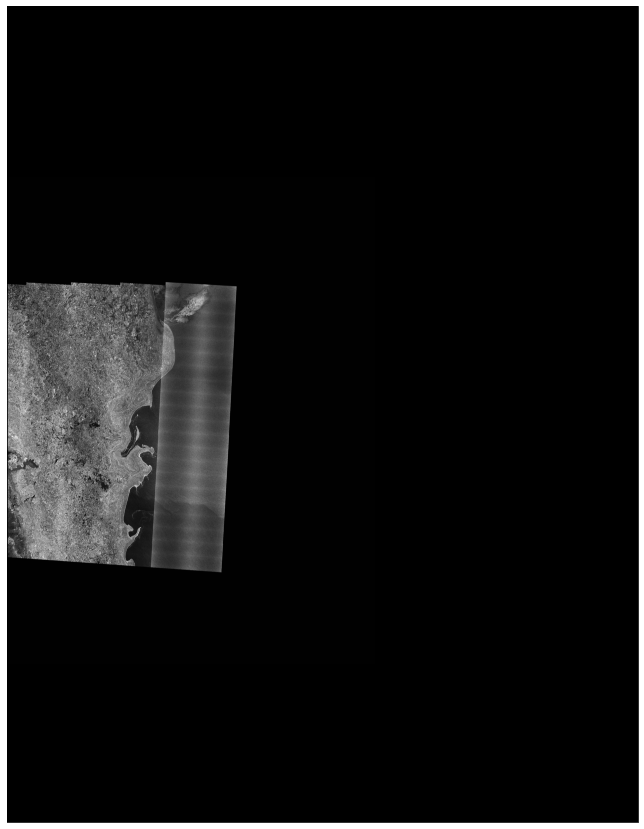

In [113]:
# plot deformation on top of the SAR image

plt.figure(figsize=(15,15))
ax = plt.axes(projection=crs)

# Compute the transformed values
shear_values = e2 * 24 * 60 * 60 * 100

# Create a mask for values less than or equal to 40
masked_values = np.where(shear_values > 10, shear_values, np.nan)

ax.imshow(n1b1, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
trp = plt.tripcolor(x1pm[gpi], y1pm[gpi], masked_values, triangles=t, vmin=0, vmax=100, cmap='plasma', mask=mask, alpha=0.5)


plt.colorbar(trp, shrink=0.5)
plt.title('Ice drift shear [%/day]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])

ax.set_xlim([x1pm.min(), x1pm.max()])
ax.set_ylim([y1pm.min(), y1pm.max()])
plt.show()

ValueError: triangles max element is out of bounds

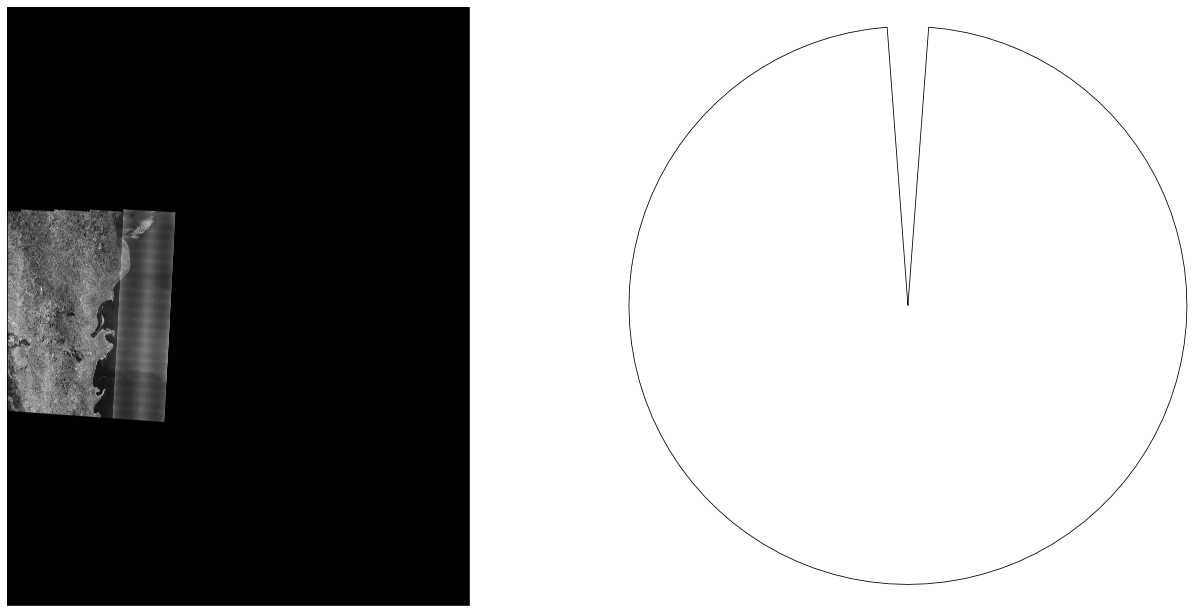

In [115]:
# without steps for visualizing 
u = upm # / delta_t
v = vpm #/ delta_t
speed = np.sqrt((v**2+u**2)) 

# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22,11), subplot_kw={'projection': crs})

# Figure 1

# Create a mask for values less than or equal to 40
masked_values = np.where(shear_values > 10, shear_values, np.nan)

ax1.imshow(n1b1, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
trp = ax1.tripcolor(x1pm[gpi], y1pm[gpi], masked_values, triangles=t, vmin=0, vmax=100, cmap='plasma', mask=mask, alpha=0.5)



# filter vectors with hessian value
#gpi = (hpm > 8)
#num_true_values = np.sum(gpi.data)
#print(f"Number of True values in gpi before filtering: {num_true_values}")

#ax1.imshow(n1b1, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
#quiv1 = ax1.quiver(x1pm[gpi][::4], y1pm[gpi][::4], u[gpi][::4], v[gpi][::4], speed[gpi][::4], scale=1000000, cmap='jet', width=0.0035)
#quiv1 = ax.quiver(x1pm[gpi][::1], y1pm[gpi][::1], u[gpi][::1], v[gpi][::1], speed[gpi][::1], scale=1000000, cmap='jet', width=0.0035)
#ax1.set_title('Ice Drift Speed before filtering[m/s]')
#ax1.add_feature(land_50m, edgecolor='black')
#ax1.set_xlim([x1pm.min(), x1pm.max()])
#ax1.set_ylim([y1pm.min(), y1pm.max()])
ax1.set_xlim([x1pm.min(), x1pm.max()-670000])
ax1.set_ylim([y1pm.min()+370000, y1pm.max()-400000])
plt.colorbar(quiv1, ax=ax1, orientation='vertical', shrink=0.5)



#  Figure 2

# Filter out values of hpm 
filtered_hpm = np.where(hpm > 0, hpm, np.nan)
h_img = ax2.imshow(filtered_hpm, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower', cmap='PiYG', alpha=1, vmin=0, vmax=30)
#ax2.set_title('Hessian > 9')
ax2.add_feature(land_50m, edgecolor='black')
ax2.set_xlim([x1pm.min(), x1pm.max()-670000])
ax2.set_ylim([y1pm.min()+370000, y1pm.max()-400000])
plt.colorbar(h_img, ax=ax2, shrink=0.5)



# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.06)  


#plt.tight_layout()
plt.show()



In [116]:
dayssec = total_time_diff

# compute ice drift speed [m/s]
delta_t = dayssec #in seconds
u = upm / delta_t
v = vpm / delta_t
speed = np.sqrt((v**2+u**2)) 

# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Create a figure with three subplots side by side
plt.figure(figsize=(15,15))
ax =plt.axes(projection=crs) 

# Figure 1

# filter vectors with hessian value
gpi = (hpm > 8) 
num_true_values = np.sum(gpi.data)
print(f"Number of True values without filtering : {num_true_values}")

# Plot the image on the first subplot
#
ax.imshow(a1, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
quiv1 = ax.quiver(x1pm[gpi][::4], y1pm[gpi][::4], u[gpi][::4], v[gpi][::4], speed[gpi][::4], scale=5, cmap='jet', width=0.0035)
#quiv1 = ax.quiver(x1pm[gpi][::1], y1pm[gpi][::1], u[gpi][::1], v[gpi][::1], speed[gpi][::1], scale=2, cmap='jet', width=0.0035)
ax.set_title('Ice Drift Speed before filtering[m/s]')
#ax.add_feature(land_50m, edgecolor='black')
ax.set_xlim([x1pm.min(), x1pm.max()])
ax.set_ylim([y1pm.min(), y1pm.max()])
plt.colorbar(quiv1, ax=ax, orientation='vertical', shrink=0.5)


plt.show()


NameError: name 'total_time_diff' is not defined